In [104]:
%matplotlib inline

In [159]:
from pylab import *
import pylab
import matplotlib as mpl
import numpy
import lnm
from graph import Graph
import ipywidgets as widgets
from IPython.display import display, HTML
mpl.rcParams['savefig.dpi'] = 180
OPTIONS = {'FSM': 'results_fsm.txt',
           'Snake': 'results_snake.txt',
           'Snake New': 'results_snake_03-11-15.txt',
           'Tetris': 'results_tetris.txt',
           'Tetris New': 'results_tetris_03-11-15.txt',
           'Sieve': 'results_sieve.txt',
           'Suffix Tree': 'results_suffixtree.txt',
           'Suffix Tree New': 'results_suffixtree_03-11-15.txt',
           'Synth':'results_synth.txt'}
s = widgets.Dropdown(options=OPTIONS)

In [173]:
display(s)

In [174]:
HTML("<h1>Filename: '" + s.value + "'</h1>")

# Select Benchmark:

In [175]:
graph = lnm.read_data(s.value)
variations, data = graph.ungraph()
hidden_untyped = data[0,2]
pycket_untyped = data[0,1]
racket_untyped = data[0,0]
hidden = data[:,2]
pycket = data[:,1]
racket = data[:,0]

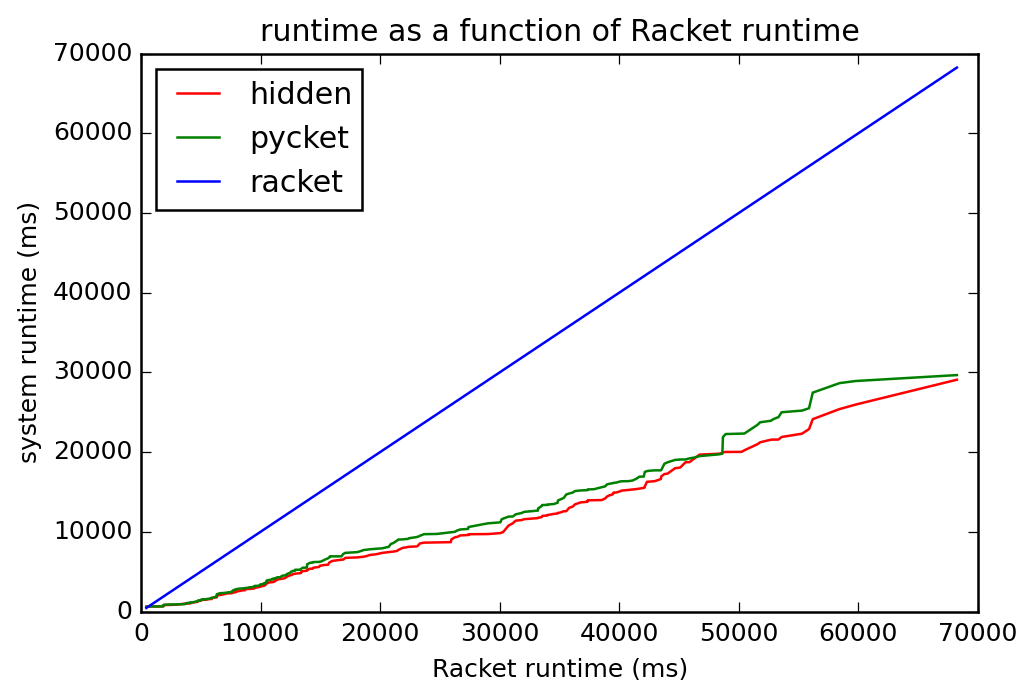

In [176]:
# Runtime of Pycket as a function of Racket
ordered_data = np.copy(data)
ordered_data.sort(axis=0)
ohidden = ordered_data[:,2]
opycket = ordered_data[:,1]
oracket = ordered_data[:,0]
pylab.plot(oracket, ohidden, 'r', label='hidden')
pylab.plot(oracket, opycket, 'g', label='pycket')
pylab.plot(oracket, oracket, 'b', label='racket')
pylab.title('runtime as a function of Racket runtime')
pylab.xlabel('Racket runtime (ms)')
pylab.ylabel('system runtime (ms)')
pylab.legend(loc='best')

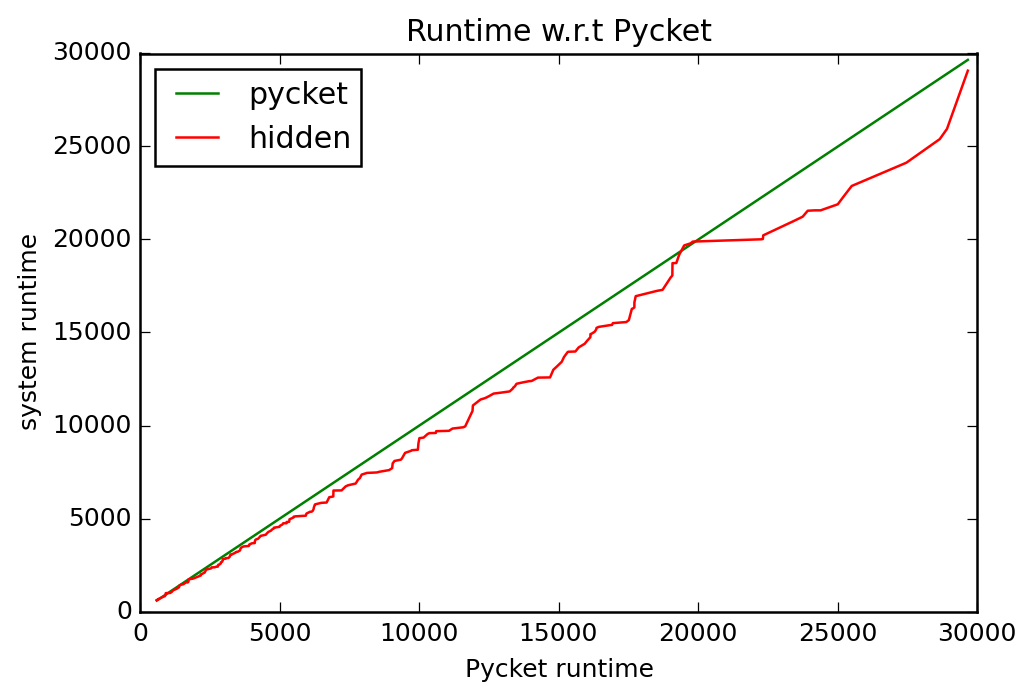

In [177]:
pylab.plot(opycket, opycket, 'g', label='pycket')
pylab.plot(opycket, ohidden, 'r', label='hidden')
pylab.title('Runtime w.r.t Pycket')
pylab.xlabel('Pycket runtime')
pylab.ylabel('system runtime')
pylab.legend(loc='best')

In [178]:
from scipy.stats import cumfreq
from pandas      import DataFrame
from ipy_table   import *

hidden_slowdown = hidden / float(hidden_untyped)
pycket_slowdown = pycket / float(pycket_untyped)
racket_slowdown = racket / float(racket_untyped)

def make_slowdown_data(fname):
    data = np.genfromtxt(fname, usecols=(1,2,3))
    hidden_untyped = float(data[0,2])
    pycket_untyped = float(data[0,1])
    racket_untyped = float(data[0,0])
    hidden = data[:,2]
    pycket = data[:,1]
    racket = data[:,0]
    return racket / racket_untyped, pycket / pycket_untyped, hidden / hidden_untyped

def compute_deliverable(data):
    th = sum(data < 3)
    oh = sum(numpy.logical_and(data >= 3, data < 10))
    return [max(data), numpy.mean(data), np.median(data), "%d (%0.2f%%)" % (th, th / float(len(data)) * 100), "%d (%0.2f%%)" % (oh, oh / float(len(data)) * 100)]

def make_deliverable_table(**kwargs):
    lst = [["", "Max overhead", "Mean overhead", "Median overhead", "300-deliverable", "300/1000-usable"]]
    for name, data in kwargs.iteritems():
        lst.append([name] + compute_deliverable(data))
    tbl = make_table(map(list, zip(*lst)))
    apply_theme('basic_both')
    return tbl

def slowdown_cdf(*args):
    for data, color, label in args:
        counts, bin_edges = numpy.histogram(data, bins=len(data))
        cdf = numpy.cumsum(counts)
        pylab.plot(bin_edges[:-1], cdf, color=color, label=label)
    pylab.axvline(3, color='y')
    pylab.axvline(10, color='k')
    pylab.axhline(len(data) * 0.6, color='c', ls='--')
    pylab.xlabel('slowdown factor')
    pylab.xlim((1,20))
    pylab.ylim((0,len(racket)))
    pylab.ylabel('number below')
    pylab.legend(loc='best')
    
def compute_lnm_deliverable(slowdown_graph, L):
    graph = lnm.compute_lnm_times(slowdown_graph, L)
    data = graph.ungraph()[1]
    rs = data[:,0]
    ps = data[:,1]
    hs = data[:,2]
    return rs, ps, hs, make_deliverable_table(racket=rs, pycket=ps,hidden=hs)
    

# Slowdown Summary Stats

In [179]:
DataFrame({'racket':racket_slowdown, 'pycket':pycket_slowdown, 'hidden':hidden_slowdown}).describe()

,hidden,pycket,racket
count,256.000000,256.000000,256.000000
mean,11.981593,13.425514,39.584030
std,10.095065,11.310438,30.211570
min,0.977742,0.956026,0.860465
25%,4.268283,4.777687,16.874031
50%,7.773450,8.695440,25.949612
75%,19.090620,21.757736,65.248062
max,46.227345,48.302932,132.240310


# Deliverability Stats

## L = 0

In [180]:
slowdown_graph = lnm.fromkeyvals(variations, racket_slowdown, pycket_slowdown, hidden_slowdown)
racket_slowdown0, pycket_slowdown0, hidden_slowdown0, tbl = compute_lnm_deliverable(slowdown_graph, 0)
tbl

,racket,hidden,pycket
Max overhead,132.2403,46.2273,48.3029
Mean overhead,39.5840,11.9816,13.4255
Median overhead,25.9496,7.7734,8.6954
300-deliverable,4 (1.56%),40 (15.62%),39 (15.23%)
300/1000-usable,22 (8.59%),107 (41.80%),99 (38.67%)


## L = 1

In [181]:
racket_slowdown1, pycket_slowdown1, hidden_slowdown1, tbl = compute_lnm_deliverable(slowdown_graph, 1)
tbl

,racket,hidden,pycket
Max overhead,29.7364,8.3577,9.6906
Mean overhead,12.4315,3.2531,3.5513
Median overhead,12.0310,2.7742,2.8143
300-deliverable,18 (7.03%),136 (53.12%),133 (51.95%)
300/1000-usable,85 (33.20%),120 (46.88%),123 (48.05%)


## L = 2

In [182]:
racket_slowdown2, pycket_slowdown2, hidden_slowdown2, tbl = compute_lnm_deliverable(slowdown_graph, 2)
tbl

,racket,hidden,pycket
Max overhead,20.3256,5.4420,6.0668
Mean overhead,6.3530,1.7254,1.8183
Median overhead,4.4341,1.3482,1.4381
300-deliverable,60 (23.44%),232 (90.62%),229 (89.45%)
300/1000-usable,139 (54.30%),24 (9.38%),27 (10.55%)


# Slowdown distribution

## L = 0

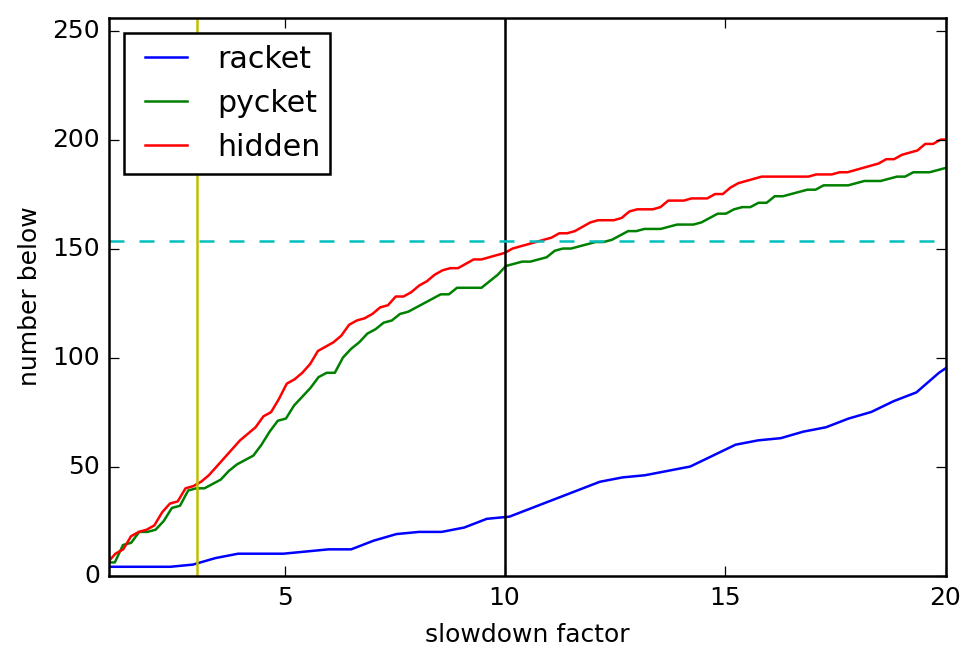

In [183]:
slowdown_cdf((racket_slowdown0, 'b', 'racket'),
             (pycket_slowdown0, 'g', 'pycket'),
             (hidden_slowdown0, 'r', 'hidden'))

## L = 1

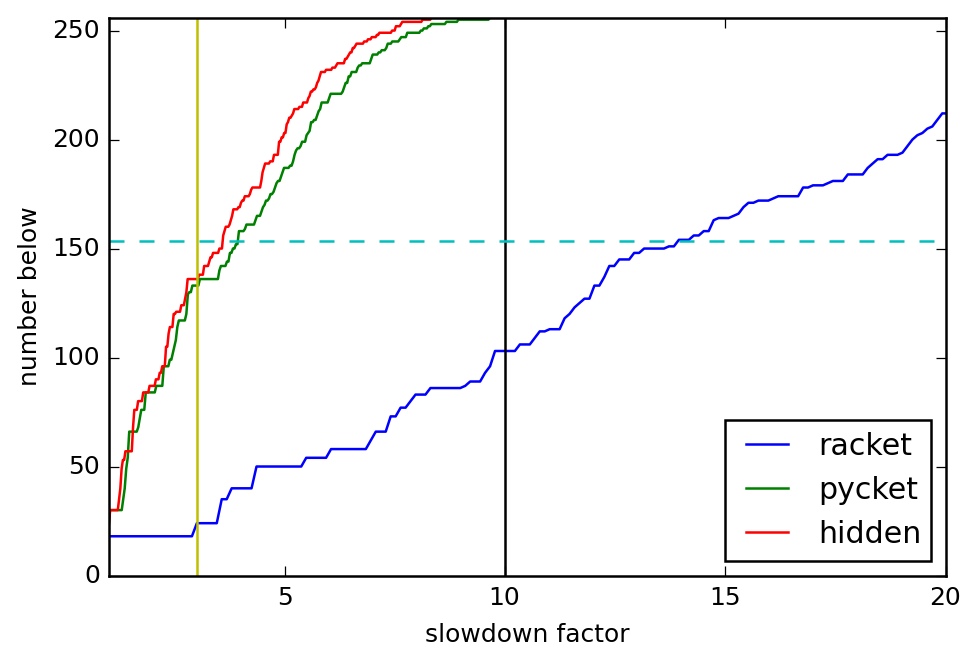

In [184]:
slowdown_cdf((racket_slowdown1, 'b', 'racket'),
             (pycket_slowdown1, 'g', 'pycket'),
             (hidden_slowdown1, 'r', 'hidden'))

## L = 2

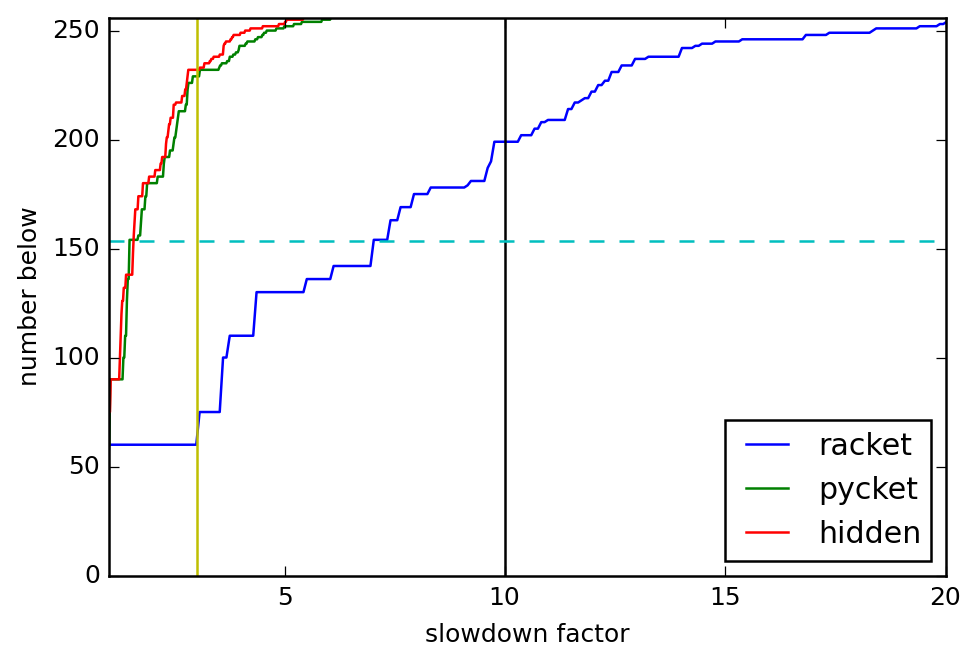

In [185]:
slowdown_cdf((racket_slowdown2, 'b', 'racket'),
             (pycket_slowdown2, 'g', 'pycket'),
             (hidden_slowdown2, 'r', 'hidden'))